<a href="https://colab.research.google.com/github/atran163/Data-301/blob/master/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Research Question: Airbnb Prices in NYC 
NYC is a very diverse area known for its 5 boroughs. These boroughs vary drastically in terms of people, culture, and income. Does Airbnb display these variations through its listings as well? Do prices change from borough to borough and how significant are these changes? Can we also accurately predict prices and make suggestions for houses just like Airbnb does? We will see below in our Data 301 Final Project which is broken up into 3 parts: EDA, Machine Learning, and Final Conclusion. Goal: Predict Price Based on Certain Features

# Imports and Data 

The data and manipulations we needed from earlier to run our machine learning aspect. Also includes imports specifically for machine learning.

In [0]:
# to read the data
import pandas as pd
import numpy as np
import sys
sys.setrecursionlimit(10000000)
import json
from pandas.io.json import json_normalize
import sklearn 
import warnings # the below imports were to stop displaying warnings for aesthetic appeal
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns


# imports specifically for data collection
from folium.plugins import MarkerCluster
import folium
import matplotlib.pyplot as plt

#imports just for machine learning
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [0]:
df_bnb = pd.read_csv("listings.csv", error_bad_lines=False, encoding = "utf8")
df = df_bnb.filter(["id", "name", "summary", "space", "description", "host_id", "host_response_rate",
                     "host_is_superhost", "street", "neighbourhood", "city", "latitude", "longitude", 
                     "property_type", "room_type", "bathrooms", "bedrooms", "beds", "bed_type", "amenities", 
                     "square_feet", "price", "cleaning_fee", "number_of_reviews", "review_scores_rating"]) 
df = df[df.price.str.startswith("$", na=False) == True]
df["price_int"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
df2 = df[df.price_int < 650]
df2 = df2[df2.price_int > 50]
subways = json.load(open('ny_subways.json'))
df_json_subway = json_normalize(subways, "data")
df_subway = pd.DataFrame()
df_subway = df_json_subway[11].str.split().apply(pd.Series)
df_subway["longitude"] = df_subway[1].str.replace("(", "")
df_subway["latitude"] = df_subway[2].str.replace(")", "")
del df_subway[0], df_subway[1], df_subway[2]
df_subway["latitude_int"] = df_subway["latitude"].astype(float)
df_subway["longitude_int"] = df_subway["longitude"].astype(float)
joined = pd.read_csv("neighbourhoods.csv")  # another CSV file to join on 
df = df.merge(joined, on=["neighbourhood"])
df = df.rename(columns={"neighbourhood_group": "boroughs"}) # renaming the column
df2 = df[df.price_int < 650]
df2 = df2[df2.price_int > 50]
df2["latitude_int"] = df2["latitude"].astype(float)
df2["longitude_int"] = df2["longitude"].astype(float)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#cleaning the data 
df2["host_response_rate"].fillna(0, inplace = True)
df2["property_type"].fillna("other", inplace = True)
df2["room_type"].fillna("other", inplace = True)
df2["bathrooms"].fillna(0, inplace = True)
df2["bedrooms"].fillna(0, inplace = True)
df2["beds"].fillna(0, inplace = True)
df2["bed_type"].fillna("other", inplace = True)
df2["square_feet"].fillna(0, inplace = True)
df2["cleaning_fee"].fillna(0, inplace = True)
df2["price"].fillna(0, inplace = True)
df2["number_of_reviews"].fillna(0, inplace = True)
df2["review_scores_rating"].fillna(0, inplace = True)
df2["boroughs"].fillna("other", inplace = True)
df = df[df.cleaning_fee.str.startswith("$", na=False) == True]
df2["cleaning_fee_int"] = df["cleaning_fee"].str.replace("$", "").str.replace(",", "").astype(float)
df2["cleaning_fee_int"].fillna(0, inplace = True)
df2["price_int"].fillna(0, inplace = True)
df2["host_response_rate_int"] = df["host_response_rate"].str.replace("%", "").str.replace(",", "").astype(float)
df2["host_response_rate_int"].fillna(0, inplace = True)


# Machine Learning 

We learned many many machine learning techniques and models to make predictions. Let's see how well we can do with predicting price. A big factor that Airbnb works with is predicting prices. Can we imitate their data scientits to make those same predictions?

### K-Neighbors Regresssor

When it comes to prediction, our research question involved predicting price from attributes of an Airbnb. But, what attributes work best? We will use K-Neighbors Regressor to predict the price off of variables we think are best. We will then see which combination of these variables produces the lowest RMSE. We hypothesized that location, number of bathrooms, number of bedrooms, square footage, and rating are our best predictors.

In [0]:
# calculate estimate of test error for a given feature set
def get_cv_error(features):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=20)
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df2[features], 
                             y=df2["price_int"],
                             scoring="neg_mean_squared_error", cv=10)
  
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [
                 ["latitude_int", "longitude_int"],
                 ["latitude_int", "longitude_int", "bathrooms"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating", "number_of_reviews"]]:
  errs[str(features)] = get_cv_error(features)
np.sqrt(errs)

['latitude_int', 'longitude_int']                                                                                         86.649092
['latitude_int', 'longitude_int', 'bathrooms']                                                                            82.708599
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms']                                                                71.654620
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet']                                                 71.788255
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet', 'review_scores_rating']                         71.748626
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet', 'review_scores_rating', 'number_of_reviews']    71.708020
dtype: float64



*  Interpretation: Our lowest RMSE is using 7 predictor variables: latitude, longitude, bathrooms, bedrooms, square_feet, rating, and number of reviews. The RMSE is 71.708 which means that our predictions are off by 71 dollars.



Now that we saw which predictor variables are best, let's see which value of K for our KNR minimizes our RMSE. We will create training and test data from our best predictors and using train_test_split

In [0]:
X = df2[["latitude_int", "longitude_int", "bathrooms", "bedrooms", 
         "square_feet", "review_scores_rating", "number_of_reviews"]]
y = df2["price_int"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

19    4914.113217
18    4916.656675
20    4917.497067
32    4920.827432
23    4922.554445
dtype: float64

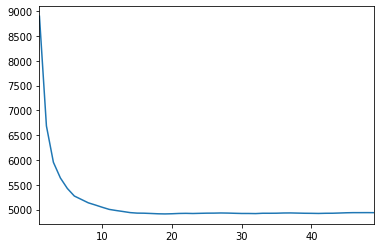

In [0]:
# calculate estimate of test error for a value of k
def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k)
  ) 
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()
    
ks = pd.Series(range(1, 50))
ks.index = range(1, 50)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values().head(5)



*   Our best value of neighbors is 19 neigbors!



### Linear Regression

After trying KNR, let's see if linear regression can make better predictions by reducing the RMSE. We will also use cross-validation to look at the RMSE between different predictor variables.  

In [0]:
# calculate estimate of test error for a given feature set
def get_cv_error(features):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      LinearRegression()
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df2[features], 
                             y=df2["price_int"],
                             scoring="neg_mean_squared_error", cv=10)
  
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [
                 ["latitude_int", "longitude_int"],
                 ["latitude_int", "longitude_int", "bathrooms"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating", "number_of_reviews"]]:
  errs[str(features)] = get_cv_error(features)
np.sqrt(errs)

['latitude_int', 'longitude_int']                                                                                         89.763221
['latitude_int', 'longitude_int', 'bathrooms']                                                                            86.457798
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms']                                                                81.288435
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet']                                                 81.253258
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet', 'review_scores_rating']                         81.002703
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet', 'review_scores_rating', 'number_of_reviews']    80.927038
dtype: float64

Our lowest MSE is still the same 7 predictor variables: latitude, longitude, bathrooms, bedrooms, square_feet, rating, and number of reviews. The MSE however this time is 80.93 which means that our predictions are off by 81 dollars. This is a bigger error than K-neighbors. Because our data was so skewed, would taking the log of price reduce our MSE closer to that of K-neighbors?

In [0]:
df2["log_price"] = np.log(df2["price_int"])
# calculate estimate of test error for a given feature set
def get_cv_error(features):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      LinearRegression()
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df2[features], 
                             y=df2["log_price"],
                             scoring="neg_mean_squared_error", cv=10)
  
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [
                 ["latitude_int", "longitude_int"],
                 ["latitude_int", "longitude_int", "bathrooms"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating"],
                 ["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating", "number_of_reviews"]]:
  errs[str(features)] = get_cv_error(features)
np.sqrt(errs)

['latitude_int', 'longitude_int']                                                                                         0.519779
['latitude_int', 'longitude_int', 'bathrooms']                                                                            0.510140
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms']                                                                0.482419
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet']                                                 0.482243
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet', 'review_scores_rating']                         0.481247
['latitude_int', 'longitude_int', 'bathrooms', 'bedrooms', 'square_feet', 'review_scores_rating', 'number_of_reviews']    0.480942
dtype: float64

 Interpreting Root MSE for log(price) is a bit tricky and can cause confusion when comparing to just price itself. Let's run our best model and back-transform the results to get a more interpretable and comparable number.

In [0]:
X = df2[["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating", "number_of_reviews"]]
y = df2["log_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X_train, y_train) 
predict_log_price = pipeline.predict(X_test) 
predict_price = np.exp(predict_log_price) 
exp_price = np.exp(y_test) 
np.sqrt(sklearn.metrics.mean_squared_error(exp_price, predict_price)) 

85.06373141545657

Ah a more interpretable number. Note, that this MSE is not calculated with cross-validation. We wanted to manually back transform our variables and we found that our MSE to be bigger than all of our attempted methods!

### Random Forest Classifier

Now that we've predicted price, can we go kind of backwards and predict which bourough a listing is in? We will do this using random forest classifier

In [0]:
X = df2[["latitude_int", "longitude_int", "bathrooms", "bedrooms", "square_feet", "review_scores_rating", "number_of_reviews"]]
y = df2["boroughs"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(max_depth=2, random_state=0, class_weight = "balanced")
)
# calculate errors from cross-validation
cv_errs = cross_val_score(pipeline, X=X, 
                          y=df2["boroughs"],
                          scoring="f1_micro", cv=10)
# calculate average of the cross-validation errors
cv_errs.mean()

0.5790681507537195

Our f1 score is okay, it's not the best. But what does this mean? Let's visualize it with a confusion matrix 

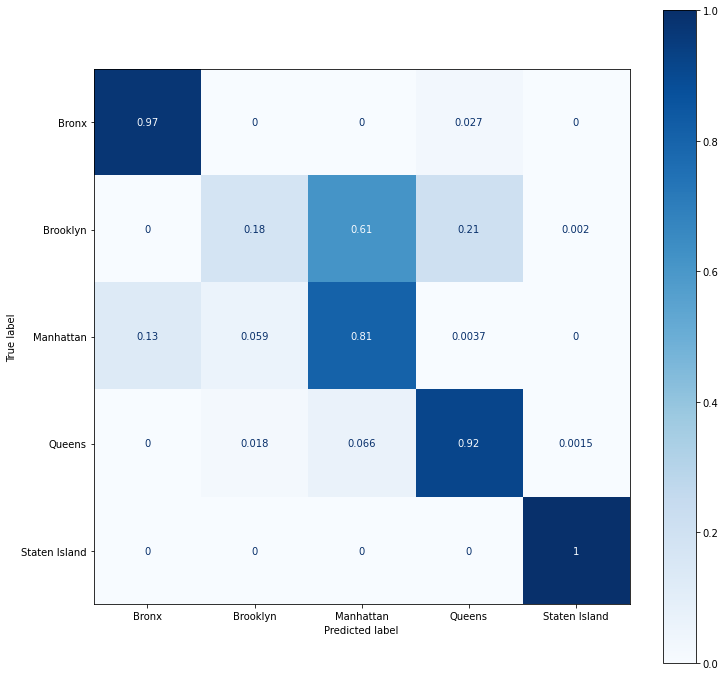

In [0]:
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight= "balanced")
clf.fit(X_train, y_train)
predicted_boroughs = clf.predict(X_test)

cmatrix = confusion_matrix(y_test, predicted_boroughs, labels=y_test.unique())

fig, ax = plt.subplots(figsize=(12,12))
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize="true", 
                                 ax = ax)